In [12]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

from PIL import Image
from PIL import ImageEnhance
from PIL import ImageOps
import matplotlib.patches as patches

from matplotlib import gridspec

# Problem 1

# a.)

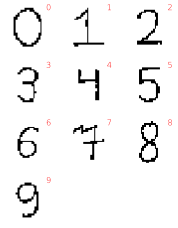

In [25]:
digits_raw = []
labels = []

for i in range(10):
    filename = 'Numbers/Phys594_HW4_N' + str(i) + '.png'
    image = Image.open(filename)
    image = image.convert(mode = 'L')
    digits_raw.append(image)
    labels.append(i)

labels = np.array(labels)

digits_centered = []

for digit in digits_raw:

    inv_sample = ImageOps.invert(digit)
    bbox = inv_sample.getbbox()
    rect = patches.Rectangle(
        (bbox[0], bbox[3]), bbox[2]-bbox[0], -bbox[3]+bbox[1]-1,
        fill=False, alpha=1, edgecolor='w')

    crop = inv_sample.crop(bbox)

    new_size = 140
    delta_w = new_size - crop.size[0]
    delta_h = new_size - crop.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(crop, padding)
    
    digits_centered.append(new_im)

def normalize(img_in):
    img = np.asarray(img_in)
    
    max_val = float(img.max())
    
    x_dim, y_dim = img.shape

    norm_img = np.zeros_like(img)

    for i in range(x_dim):
        for j in range(y_dim):
            norm_img[i, j] = img[i, j] / max_val
    
    return norm_img

def downscale(img_source, x0_raw, x1_raw):
    x_dim, y_dim = img_source.shape
    x0 = np.floor(x0_raw * x_dim*0.9999).astype(int)
    x1 = np.floor(x1_raw * y_dim*0.9999).astype(int)
    return img_source[x0, x1]

digits_norm = []

for digit in digits_centered:
    digits_norm.append(normalize(digit))

my_digits = []

grid_size = 28
extent = [0, 1, 0, 1]

X = np.meshgrid(np.linspace(extent[0],extent[1],grid_size,dtype=float),
                np.linspace(extent[2],extent[3],grid_size,dtype=float), indexing='ij')

for digit in digits_norm:
    result = downscale(digit, *X)
    my_digits.append(result)

my_digits = np.array(my_digits)

def plot_digit_array(x,y, show_prediction=False):
    
    num_digits = x.shape[0]
    num_cols = int(np.sqrt(num_digits))
    num_rows = num_digits//num_cols + 1

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    
    for i,cax in enumerate(ax.flatten()):
        if i < num_digits:
            cax.matshow(x[i].reshape(28,28), cmap='binary')
            cax.axis('off')
            if show_prediction:
                cax.text(0.99,0.99,f'{y[i]}',horizontalalignment='right',verticalalignment='top', 
                         transform=cax.transAxes, fontsize=8, color='r')
        else:
            cax.axis('off')


plot_digit_array(my_digits, labels, True)

# b.)

In [26]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# determine the properties
rows,cols = x_train[0].shape
num_classes = 10

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# use a built-in function to get 1-hot encoding
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

y_test_hot = keras.utils.to_categorical(labels, num_classes)
x_test = my_digits.reshape(my_digits.shape[0], rows, cols, 1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 7)         182       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 343)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                3440      
Total params: 3,622
Trainable params: 3,622
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
938/938 [==============================] - 18s 19ms/step - loss: 0.9062 - accuracy: 0.7360 - val_loss: 1.5250 - val_accuracy: 0.6000
Epoch 2/10
938/938 [==============================] - 17s 19ms/step - loss: 0.1874 - accuracy: 0.9447 - va

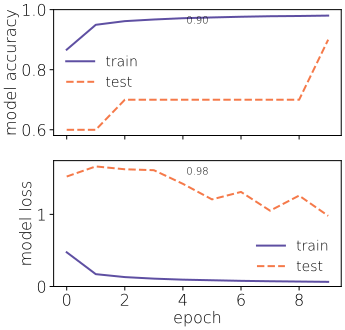

In [31]:
# instantiate model
model = keras.Sequential(
[
    layers.Conv2D(input_shape=(rows,cols, 1), kernel_size=(5, 5), filters=7,
                  activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(4, 4)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# compile 
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])

model.summary()

batch_size = 64
epochs = 10

training = model.fit(x_train,y_train_hot, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test_hot))

# look into training history
fig,ax = plt.subplots(2,1, sharex=True, figsize=(5,5))

score = model.evaluate(x_test, y_test_hot, verbose=0);

# accuracy
ax[0].plot(training.history['accuracy'], color=colors[0])
ax[0].plot(training.history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].text(0.5,0.95,f'{score[1]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[0].transAxes)
ax[0].set_ylim(top=1)

# loss
ax[1].plot(training.history['loss'], color=colors[0])
ax[1].plot(training.history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylim(bottom=0)
ax[1].text(0.5,0.95,f'{score[0]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[1].transAxes)
ax[1].legend(['train', 'test'], loc='best');

print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

predictions_prob_train = model(x_train)
predictions_prob_test = model(x_test)

predictions_train = np.argmax(predictions_prob_train,axis=1)
predictions_test = np.argmax(predictions_prob_test,axis=1)

mistakes_train = np.where(predictions_train != y_train)[0]
mistakes_test = np.where(predictions_test != labels)[0]

num_mistakes_train,num_mistakes_test = len(mistakes_train),len(mistakes_test)

print(f'Train Mistakes: {100*num_mistakes_train/x_train.shape[0]:.2f}%')
print(f'Test Mistakes : {100*num_mistakes_test/x_test.shape[0]:.2f}%')

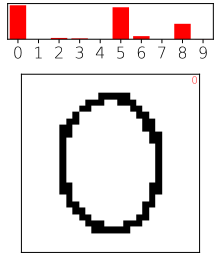

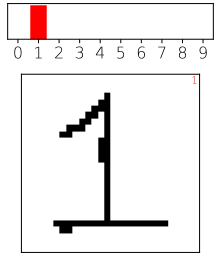

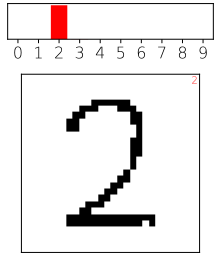

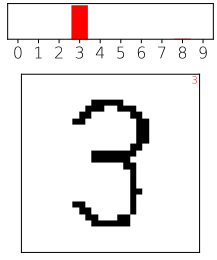

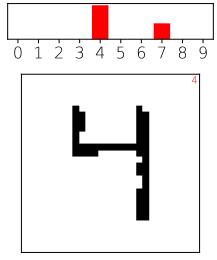

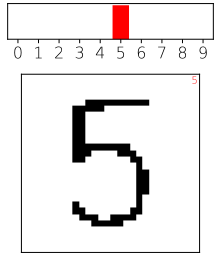

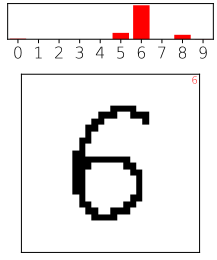

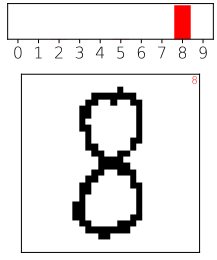

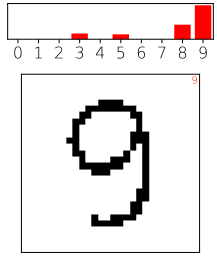

In [33]:
correct_train = np.where(predictions_train == y_train)[0]
correct_test = np.where(predictions_test == labels)[0]

for idx in correct_test:

    fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

    ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

    ax[0].bar(range(num_classes),predictions_prob_test[idx], color='r')
    ax[0].set_xticks(range(num_classes))
    ax[0].set_yticks([]);
    ax[0].set_xlim(-0.5,9.5)

    ax[1].matshow(x_test[idx,:].reshape(rows,cols), cmap='binary')
    ax[1].text(0.99,0.99,f'{predictions_test[idx]}',horizontalalignment='right',verticalalignment='top', 
                             transform=ax[1].transAxes, color='r')
    ax[1].set_xticks([]);
    ax[1].set_yticks([]);

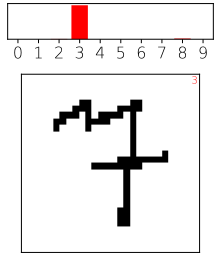

In [32]:
for idx in mistakes_test:

    fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

    ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

    ax[0].bar(range(num_classes),predictions_prob_test[idx], color='r')
    ax[0].set_xticks(range(num_classes))
    ax[0].set_yticks([]);
    ax[0].set_xlim(-0.5,9.5)

    ax[1].matshow(x_test[idx,:].reshape(rows,cols), cmap='binary')
    ax[1].text(0.99,0.99,f'{predictions_test[idx]}',horizontalalignment='right',verticalalignment='top', 
                             transform=ax[1].transAxes, color='r')
    ax[1].set_xticks([]);
    ax[1].set_yticks([]);

I got all my numbers correct except for 7, and I draw my 7's very weirdly, so I guess that makes sense.